In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE

In [2]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bionlp13cg_md-0.2.5.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_ner_bionlp13cg_md: filename=en_ner_bionlp13cg_md-0.2.5-py3-none-any.whl size=80006770 sha256=1e57ac560a351646dbef026899cac49ae1e99b7bfdb3cc9e4d371ed4e465bb78
  Stored in directory: /root/.cache/pip/wheels/3f/48/06/0b10d7df989031301ac11531d0347d0bae25170b78eca0f268
Successfully built en_ner_bionlp13cg_md


A method to get unique words(vocabulary) and sentence count in a list of text



In [3]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1
    word_count = len(vocab.keys())
    return sent_count,word_count

Lets do some exploratory analysis of data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# load the dataset

clinical_text_df = pd.read_csv('/content/mtsamples.csv')
print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 140235
Number of unique words in transcriptions column: 35805
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

Since some catgeories have less than 50 samples we remove them



In [7]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


Lets plot the categories

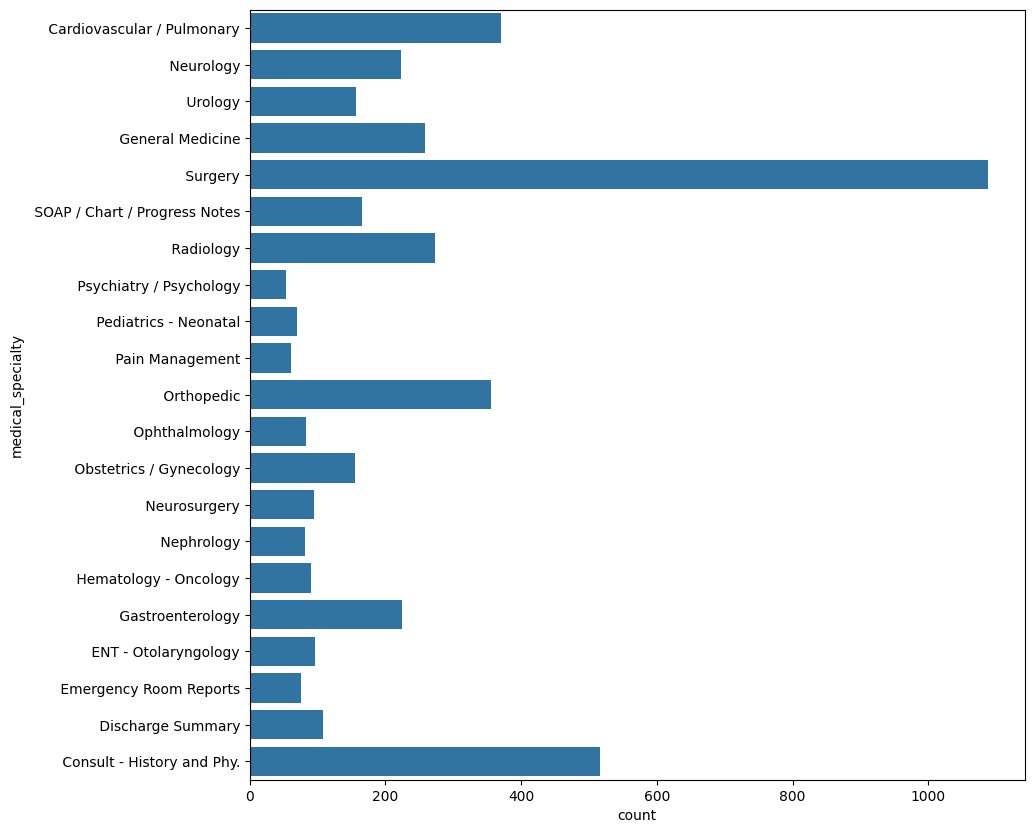

In [8]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

We are interested only in the 'transcription' and 'medical_specialty' columns in the dataset

In [9]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(4597, 2)

In [10]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETOH.,ROS:, I

Lets define soome methods for cleaning the data



In [11]:
def clean_text(text ):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()])
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer()
    sentences=sent_tokenize(text)

    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]

    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist)

Lets clean the data



In [12]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [14]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:cc   confusion and slurred speech  hx   primarily obtained from boyfriend   this  yo rhf experienced a  flulike illness  week prior to presentation  obgyn exam including cervical biopsy  and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix 

Sample Transcription 2:admitting diagnoses    this is scheduled for the week after discharge potentially by dr g  and the patient will discus the exact time later this week 

Sample Transcription 3:preoperative diagnoses   phimosis and adhesions  postoperative diagnoses   phimosis and adhesions  procedures performed   circumcision and release of ventral chordee  anesthesia   local mac  estimated blood loss   minimal  fluids   crystalloid  plan wa for removal of the dressing tomorrow 


Lets us peform feature extraction using TfidfVectorizer to generate tf-idf features. For more on tf-idf check here: https://en.wikipedia.org/wiki/Tf%E2%80%93idf In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.



In [15]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abscess', 'activity', 'acute', 'additional', 'adenocarcinoma', 'adequate', 'administered', 'admission', 'admitted', 'admitting', 'africanamerican', 'age', 'ago', 'airway', 'alcohol', 'anemia', 'anesthesia', 'anesthesia care', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthetic', 'angina', 'angiography', 'ankle', 'anterior', 'antibiotic', 'aortic', 'apnea', 'apparent', 'appendicitis', 'applied', 'appointment', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'arthroplasty', 'asked', 'aspect', 'aspiration', 'assessment', 'associated', 'atrial', 'atrial fibrillation', 'awakened', 'axial', 'axial ct', 'axial ct image', 'axis', 'baby', 'base', 'benefit', 'benign', 'better', 'bid', 'bilateral', 'bilaterally', 'biopsy', 'bladder', 'bleeding', 'block', 'blood', 'blood loss', 'blood loss cc', 'blood loss minimal', 'blood loss ml', '

Lets visualize the tf-idf features using t-sne plot. For more on t-sne check here: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton.[1] It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. The t-sne plot shows that lot of categories are overlapping with each other.



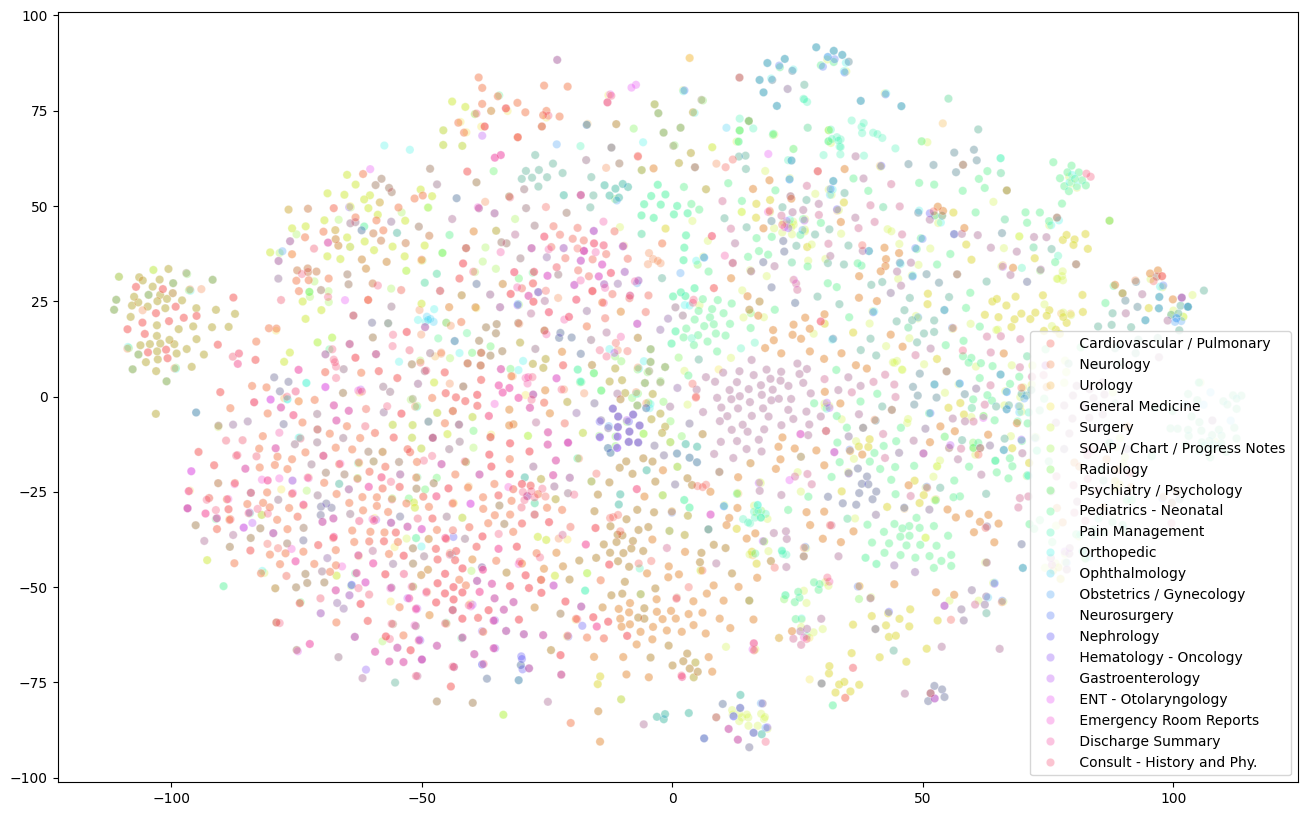

In [16]:
import gc
gc.collect()

# Assuming you have imported necessary libraries before this point

tfIdfMatrix = tfIdfMat.todense()
tfIdfArray = np.asarray(tfIdfMatrix)  # Convert to np.array
labels = data['medical_specialty'].tolist()

tsne_results = TSNE(n_components=2, init='random', random_state=0, perplexity=40).fit_transform(tfIdfArray)

plt.figure(figsize=(16, 10))
palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=labels,
    palette=palette,
    legend="full",
    alpha=0.3
)
plt.show()

Let us do PCA to reduce dimensionality of features. https://en.wikipedia.org/wiki/Principal_component_analysis PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on



In [17]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)

In [18]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3447, 587)
Test_Set_Size:(1150, 587)


Let us use Logisitic Regression to learn on training data and predict on test data https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [19]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

Let us visualize the confusion matrix and the classification results

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred, labels= category_list)
category_list

array([' Cardiovascular / Pulmonary', ' Neurology', ' Urology',
       ' General Medicine', ' Surgery', ' SOAP / Chart / Progress Notes',
       ' Radiology', ' Psychiatry / Psychology', ' Pediatrics - Neonatal',
       ' Pain Management', ' Orthopedic', ' Ophthalmology',
       ' Obstetrics / Gynecology', ' Neurosurgery', ' Nephrology',
       ' Hematology - Oncology', ' Gastroenterology',
       ' ENT - Otolaryngology', ' Emergency Room Reports',
       ' Discharge Summary', ' Consult - History and Phy.'], dtype=object)

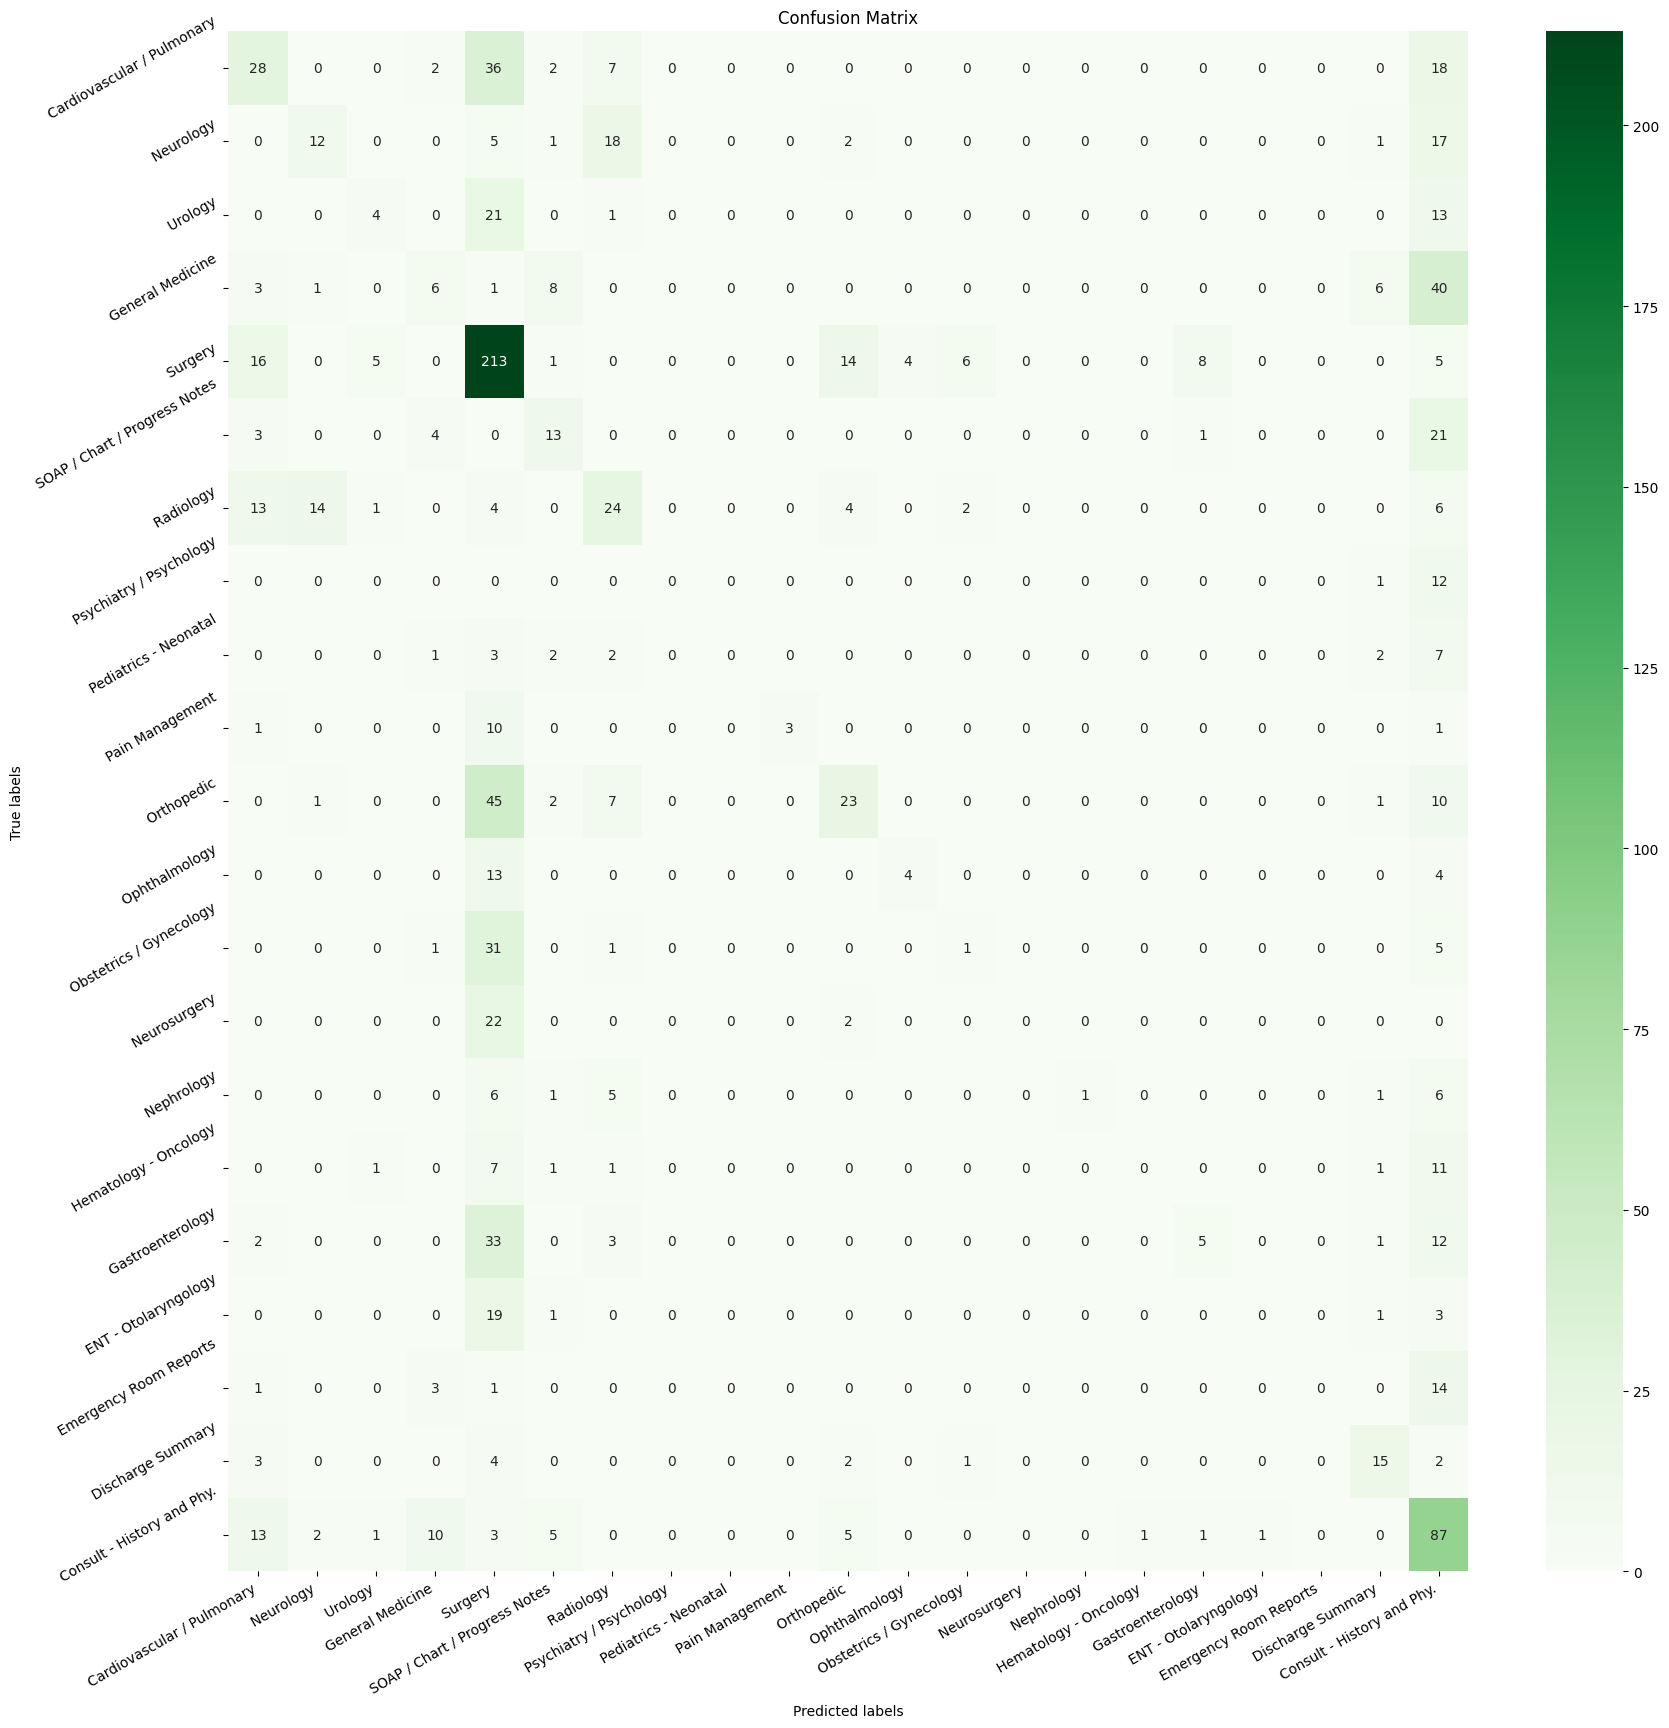

In [21]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [ ]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.34      0.30      0.32        93
                     Neurology       0.40      0.21      0.28        56
                       Urology       0.33      0.10      0.16        39
              General Medicine       0.22      0.09      0.13        65
                       Surgery       0.45      0.78      0.57       272
 SOAP / Chart / Progress Notes       0.35      0.31      0.33        42
                     Radiology       0.35      0.35      0.35        68
       Psychiatry / Psychology       0.00      0.00      0.00        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       1.00      0.20      0.33        15
                    Orthopedic       0.44      0.26      0.33        89
                 Ophthalmology       0.50      0.19      0.28        21
       Obstetrics / Gynecology       0.10      0.03      0.04  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results are quite poor. Let us apply some domain knowledge and see if we can improve the results The surgey category is kind of superset as there can be surgeries belonging to specializations like cardiology,neurolrogy etc. Similarly other categories like Emergency Room Reports, Discharge Summary, Notes also overlap with specialities. Hence i remove them.



In [22]:
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 Consult - History and Phy. : 516
Cat:3 Discharge Summary : 108
Cat:4 ENT - Otolaryngology : 96
Cat:5 Emergency Room Reports : 75
Cat:6 Gastroenterology : 224
Cat:7 General Medicine : 259
Cat:8 Hematology - Oncology : 90
Cat:9 Nephrology : 81
Cat:10 Neurology : 223
Cat:11 Neurosurgery : 94
Cat:12 Obstetrics / Gynecology : 155
Cat:13 Ophthalmology : 83
Cat:14 Orthopedic : 355
Cat:15 Pain Management : 61
Cat:16 Pediatrics - Neonatal : 70
Cat:17 Psychiatry / Psychology : 53
Cat:18 Radiology : 273
Cat:19 SOAP / Chart / Progress Notes : 166
Cat:20 Urology : 156
============Reduced Categories======================


(2324, 2)

Let us use sciscpacy models to detect medical entities in our text scispaCy is a Python package containing spaCy models for processing biomedical, scientific or clinical text. For more on scispacy check here:https://allenai.github.io/scispacy/

